### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Import data into tensorflow dataset object

In [2]:
# Constants
IMAGE_SIZE = 224  # Replace with your desired image size
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/riceleaf/Dataset4'  # Path to your dataset directory
CLASS_NAMES = os.listdir(DATASET_DIR)

# Prepare a list of all image paths and corresponding labels
image_paths = []
labels = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Create a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})


In [3]:
# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, stratify=train_data['label'], random_state=42)  # 0.25 x 0.8 = 0.2


In [4]:
# def sequence_data_generator(generator, sequence_length):
#     while True:
#         images, labels = next(generator)
#         batch_size = images.shape[0]
#         # Reshape to create sequences (assuming batch_size is divisible by sequence_length)
#         sequences = images.reshape(batch_size // sequence_length, sequence_length, 224, 224, 3)
#         yield sequences, labels[:batch_size // sequence_length]

In [5]:
# Data Augmentation and Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important to maintain order for evaluation
)

Found 4670 validated image filenames belonging to 4 classes.
Found 668 validated image filenames belonging to 4 classes.
Found 594 validated image filenames belonging to 4 classes.


In [6]:
# SEQUENCE_LENGTH = 4
# train_generator = sequence_data_generator(train_generator, SEQUENCE_LENGTH)
# validation_generator = sequence_data_generator(validation_generator, SEQUENCE_LENGTH)
# test_generator = sequence_data_generator(test_generator, SEQUENCE_LENGTH)

In [7]:
# steps_per_epoch = len(train_generator)
# validation_steps = len(validation_generator)
# test_steps = len(test_generator)

# print(steps_per_epoch)
# print(validation_steps)
# print(test_steps)

# total_samples = test_steps * BATCH_SIZE

In [8]:
# Get class indices
class_indices = train_generator.class_indices

# Map class names to their image counts
class_counts_dict = train_data['label'].value_counts().to_dict()

# Create a list of counts in the order of train_generator.class_indices
ordered_counts = [(class_name, class_counts_dict.get(class_name, 0)) for class_name in class_indices.keys()]

# Convert to a DataFrame for better visualization
ordered_counts_df = pd.DataFrame(ordered_counts, columns=['Class Name', 'Image Count'])

# Print the ordered counts
print(ordered_counts_df)



        Class Name  Image Count
0  Bacterialblight         1246
1            Blast         1134
2        Brownspot         1260
3           Tungro         1030


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
]

In [11]:
# import numpy as np

# # Adding a dummy time dimension
# def add_dummy_dimension(generator):
#     for batch_data, batch_labels in generator:
#         yield np.expand_dims(batch_data, axis=1), batch_labels  # Add time dimension

# train_generator = add_dummy_dimension(train_generator)
# test_generator = add_dummy_dimension(test_generator)
# validation_generator = add_dummy_dimension(validation_generator)


## Building the Model

In [13]:
from tensorflow.keras.models import Model
from keras.layers import Flatten, Dense,TimeDistributed,Conv2D,MaxPooling2D,LSTM,Dropout,Reshape,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2 

strategy=tf.distribute.MirroredStrategy()
with strategy.scope():
    
    model = Sequential()
    
    # CNN Feature Extraction (using TimeDistributed for sequences)
    model.add(Conv2D(32, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.001), input_shape=(224, 224, 3))) #None for variable sequence length
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    # model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Reshape((1, -1)))
    # LSTM for Temporal Modeling
    model.add(Bidirectional(LSTM(64, return_sequences=True,dropout=0.3, recurrent_dropout=0.3))) # Keep return_sequences if you want to stack LSTMs
    model.add(Bidirectional(LSTM(32, return_sequences=False,dropout=0.3, recurrent_dropout=0.3)))
    
    # Classification
    # Dense Layers and Classification
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    # model.add(Dropout(0.3))  # Dropout in Dense layer
    model.add(Dense(4, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 200704)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 128)              │     102,793,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,863,172 (392.39 MB)

 Trainable params: 102,863,172 (392.39 MB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE ,
    # steps_per_epoch = steps_per_epoch,  # Total samples / batch_size
    validation_data=validation_generator,
    # validation_steps = validation_steps,
    epochs=30,
    callbacks = callbacks
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 94s 516ms/step - Precision: 0.1862 - Recall: 0.0017 - accuracy: 0.4040 - loss: 1.4417 - val_Precision: 0.8295 - val_Recall: 0.2186 - val_accuracy: 0.5928 - val_loss: 1.2005 - learning_rate: 1.0000e-04
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 64s 421ms/step - Precision: 0.8009 - Recall: 0.2901 - accuracy: 0.6124 - loss: 1.1337 - val_Precision: 0.8041 - val_Recall: 0.4671 - val_accuracy: 0.7156 - val_loss: 0.9417 - learning_rate: 1.0000e-04
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 64s 422ms/step - Precision: 0.7892 - Recall: 0.4714 - accuracy: 0.6682 - loss: 0.9816 - val_Precision: 0.7778 - val_Recall: 0.5659 - val_accuracy: 0.7365 - val_loss: 0.8866 - learning_rate: 1.0000e-04
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 65s 423ms/step - Precision: 0.7949 - Recall: 0.6156 - accuracy: 0.7212 - loss: 0.8588 - val_Precision: 0.7797 - val_Recall: 0.6886 - val_accuracy: 0.7455 - val_loss: 0.7860 - learning_rate: 1.0000e-04
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━

In [16]:
# Evaluate on train data
train_scores = model.evaluate(train_generator, verbose=0)
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]:.4f}, Train Precision: {train_scores[2]:.4f},Train Recall: {train_scores[3]:.4f}")

Train Loss: 0.1616, Train Accuracy: 0.9696, Train Precision: 0.9712,Train Recall: 0.9675


In [17]:

# Evaluate on test data
test_scores = model.evaluate(test_generator,verbose=0)
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]:.4f},Test Precision: {test_scores[2]:.4f},Test Recall: {test_scores[3]:.4f}")

Test Loss: 0.1387, Test Accuracy: 0.9697,Test Precision: 0.9697,Test Recall: 0.9697


In [21]:
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class indices


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


In [22]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.92      1.00      0.96       159
          Blast       0.99      0.92      0.95       144
      Brownspot       0.99      0.97      0.98       160
         Tungro       1.00      1.00      1.00       131

       accuracy                           0.97       594
      macro avg       0.98      0.97      0.97       594
   weighted avg       0.97      0.97      0.97       594



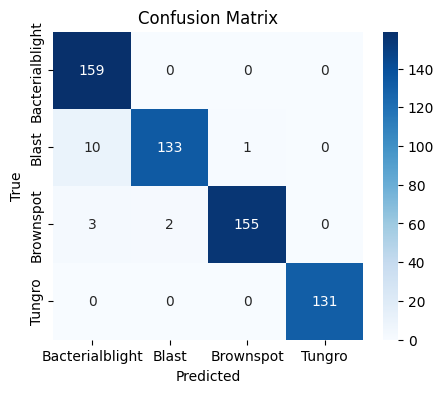

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [24]:
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='macro')  # Weighted average for class imbalance
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")

Overall Accuracy: 0.9731
Overall Precision: 0.9758
Overall Recall: 0.9731
Overall F1-Score: 0.9738


In [25]:
specificity = []

for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

overall_specificity = np.mean(specificity)  # Average specificity

print(f"Overall Specificity: {overall_specificity:.4f}")

Overall Specificity: 0.9908


In [26]:
# Sensitivity (Recall)
def calculate_specificity(cm, CLASS_NAMES):

    # Specificity
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp))

    print("\nPer-Class Specificity:")
    for idx, class_name in enumerate(CLASS_NAMES):
        print(f"Class {class_name}: {specificity[idx]:.4f}")

    return specificity

In [29]:
# print("\n--- Train Data Metrics ---")
specificity = calculate_specificity(cm, CLASS_NAMES)


Per-Class Specificity:
Class Tungro: 0.9701
Class Bacterialblight: 0.9956
Class Blast: 0.9977
Class Brownspot: 1.0000


In [30]:
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Create a DataFrame for the class-wise accuracies
class_accuracy_df = pd.DataFrame({
    "Class": list(test_generator.class_indices.keys()),
    "Accuracy": class_accuracies
})

print("\nClass-wise Accuracies:")
print(class_accuracy_df.to_string(index=False))


Class-wise Accuracies:
          Class  Accuracy
Bacterialblight  1.000000
          Blast  0.923611
      Brownspot  0.968750
         Tungro  1.000000


### Run prediction on a sample image

In [31]:
import random
from tensorflow.keras.preprocessing import image

random_indices = random.sample(range(len(y_true)), 15)

class_names = list(test_generator.class_indices.keys())

# Iterate through the random indices and display actual and predicted results
for idx in random_indices:
    actual_class = class_names[y_true[idx]]
    predicted_class = class_names[y_pred[idx]]
    print(f"Actual: {actual_class} ,  Predicted: {predicted_class}")

Actual: Bacterialblight ,  Predicted: Bacterialblight
Actual: Brownspot ,  Predicted: Brownspot
Actual: Tungro ,  Predicted: Tungro
Actual: Brownspot ,  Predicted: Brownspot
Actual: Brownspot ,  Predicted: Brownspot
Actual: Brownspot ,  Predicted: Brownspot
Actual: Blast ,  Predicted: Blast
Actual: Brownspot ,  Predicted: Brownspot
Actual: Tungro ,  Predicted: Tungro
Actual: Tungro ,  Predicted: Tungro
Actual: Blast ,  Predicted: Blast
Actual: Tungro ,  Predicted: Tungro
Actual: Blast ,  Predicted: Blast
Actual: Tungro ,  Predicted: Tungro
Actual: Bacterialblight ,  Predicted: Bacterialblight
